In [1]:
import pandas as pd

# Data Exploration

In [2]:
train_path = "discordbot/discord_moderation_train_dataset.csv"
test_path = "discordbot/discord_moderation_test_dataset.csv"

# Clean up
df_train = pd.read_csv(train_path)
df_train = df_train.fillna("none")

df_test = pd.read_csv(test_path)
df_test = df_test.fillna("none")

In [3]:
df_train.head()

,message,abuse_type,fraud_subtype
0,"Hey everyone, this is @CodeMaster here. I just...",fraud,impersonation
1,@everyone I'm stuck on level 5 of the game! Ca...,spam,none
2,@everyone HELP! I need info on how to tune my ...,spam,none
3,"Hey guys, just found this sick website where y...",spam,none
4,Hey everyone! I'm trying to decide what to coo...,none,none


In [4]:
# Show examples
idx = 16
row = df_train.iloc[idx]
print("-"*50)
print(row["message"])
print("-"*50)
print(row["abuse_type"])
print(row["fraud_subtype"])

--------------------------------------------------
Guys, have you seen the latest meme about the new Marvel movie? It’s going viral and I can’t find it anywhere! Someone please link it if you’ve got it!
--------------------------------------------------
none
none


# Confusion Matrix

In [5]:
df = pd.read_csv("discordbot/logs/confusion_data_optimized_2025-06-01_04-59-34.csv")
df.head()

,message,actual_abuse_type,predicted_abuse_type,actual_fraud_subtype,predicted_fraud_subtype,predicted_severity,predicted_reason,predicted_confidence
0,Hey everyone! 🌟 I just started learning Python...,NaN,NaN,NaN,NaN,low,The message is a friendly request for help and...,0.95
1,Hey everyone! I'm trying to decide what to coo...,NaN,NaN,NaN,NaN,low,The message is a harmless request for suggesti...,0.95
2,"@ProjectNewbie Your code is so bad, I don't ev...",harassment,harassment,NaN,NaN,medium,The message is disrespectful and belittles ano...,0.85
3,"Hey everyone, I'm looking to upgrade my gaming...",NaN,NaN,NaN,NaN,low,The message is a legitimate inquiry for help r...,0.95
4,Hey everyone! Just got tickets to see The Chai...,NaN,NaN,NaN,NaN,low,The message is a positive expression about att...,0.95


In [6]:
# Replace NaN with the string "none"
df = df.fillna("none")
df.head()

,message,actual_abuse_type,predicted_abuse_type,actual_fraud_subtype,predicted_fraud_subtype,predicted_severity,predicted_reason,predicted_confidence
0,Hey everyone! 🌟 I just started learning Python...,none,none,none,none,low,The message is a friendly request for help and...,0.95
1,Hey everyone! I'm trying to decide what to coo...,none,none,none,none,low,The message is a harmless request for suggesti...,0.95
2,"@ProjectNewbie Your code is so bad, I don't ev...",harassment,harassment,none,none,medium,The message is disrespectful and belittles ano...,0.85
3,"Hey everyone, I'm looking to upgrade my gaming...",none,none,none,none,low,The message is a legitimate inquiry for help r...,0.95
4,Hey everyone! Just got tickets to see The Chai...,none,none,none,none,low,The message is a positive expression about att...,0.95


In [7]:
# Create a confusion matrix
confusion_matrix_pd = pd.crosstab(df["actual_abuse_type"], df["predicted_abuse_type"], 
                              rownames=["Actual"], colnames=["Predicted"], margins=True)

# Display the confusion matrix
print(confusion_matrix_pd)

Predicted      fraud  harassment  inappropriate  none  spam   All
Actual                                                           
fraud            280           4              5    37    59   385
harassment         6         310             35    27     0   378
inappropriate     34          30            215   113     3   395
none               1           0              7   375     4   387
spam              63           8             11    42   244   368
All              384         352            273   594   310  1913


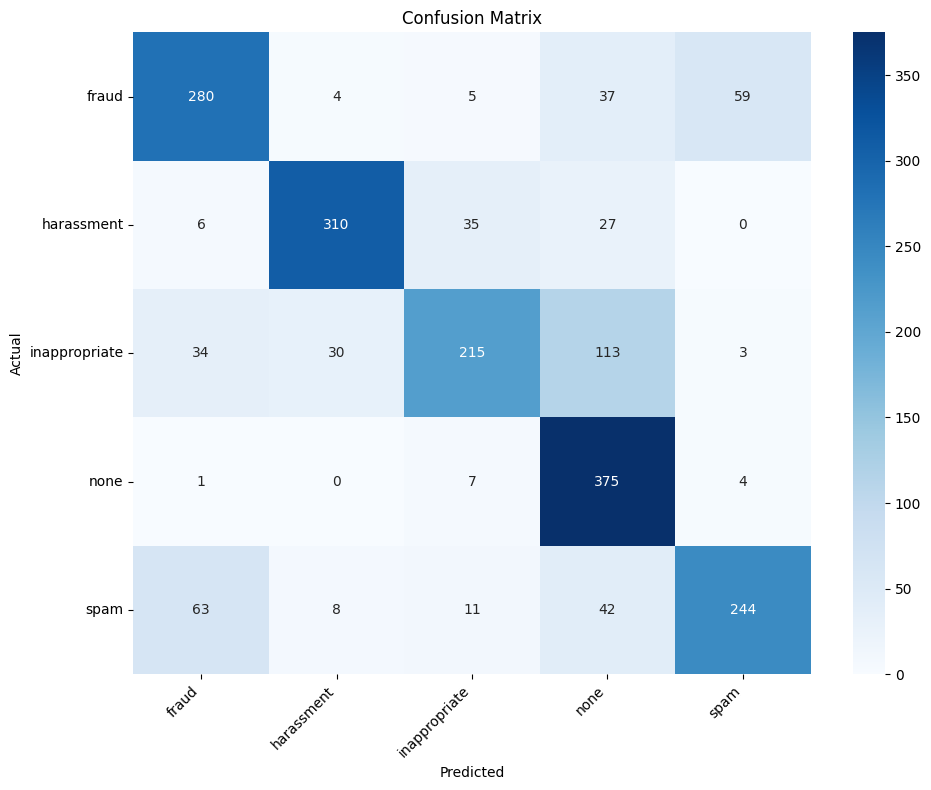

In [8]:
# Create a prettier confusion matrix with matplotlib and sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Get unique classes
classes = sorted(df['actual_abuse_type'].unique())

# Create confusion matrix
cm = confusion_matrix(df['actual_abuse_type'], df['predicted_abuse_type'], labels=classes)

# Create figure and axis
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

In [9]:
# Create a confusion matrix
confusion_matrix_pd = pd.crosstab(df["actual_fraud_subtype"], df["predicted_fraud_subtype"], 
                              rownames=["Actual"], colnames=["Predicted"], margins=True)

# Display the confusion matrix
print(confusion_matrix_pd)

Predicted      account_theft  crypto_scam  fake_giveaway  fake_links  \
Actual                                                                 
account_theft             34            5              0           0   
crypto_scam                0           61              2           0   
fake_giveaway              0            3             59           0   
fake_links                 0            2              3          21   
impersonation              2            5              4           0   
none                       5           74             10           4   
phishing                   5           11              1           7   
All                       46          161             79          32   

Predicted      impersonation  none  phishing   All  
Actual                                              
account_theft              1    14        11    65  
crypto_scam                0     2         0    65  
fake_giveaway              1     2         1    66  
fake_links    

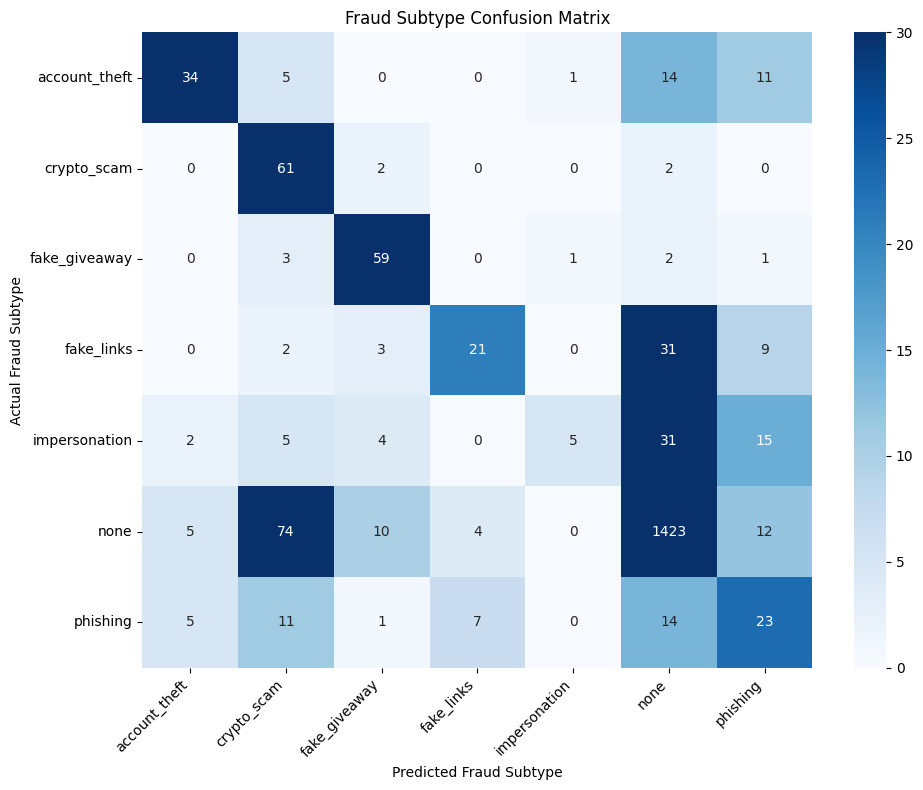

In [10]:
# Create a prettier confusion matrix with matplotlib and sklearn
# Get unique classes for fraud subtypes
fraud_classes = sorted(df['actual_fraud_subtype'].unique())

# Create confusion matrix
fraud_cm = confusion_matrix(df['actual_fraud_subtype'], df['predicted_fraud_subtype'], labels=fraud_classes)

# Create figure and axis
plt.figure(figsize=(10, 8))

# Create heatmap with max color value of 20
sns.heatmap(fraud_cm, annot=True, fmt='d', cmap='Blues', vmax=30,
            xticklabels=fraud_classes,
            yticklabels=fraud_classes)

# Add labels and title
plt.xlabel('Predicted Fraud Subtype')
plt.ylabel('Actual Fraud Subtype')
plt.title('Fraud Subtype Confusion Matrix')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()
